In [25]:
import torch
import torchvision

In [26]:
print(f'torch: {torch.__version__}')
print(f'torchvision: {torchvision.__version__}')

torch: 1.9.0+cu111
torchvision: 0.10.0+cu111


In [27]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optimizers
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
np.random.seed(1234)
torch.manual_seed(33)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [29]:
print(f'Device:{device}')

Device:cuda


In [30]:
root = os.path.join('data', 'mnist')

In [31]:
transform = transforms.Compose([
                               transforms.ToTensor(),
                               lambda x: x.view(-1)
])

In [32]:
mnist_train = torchvision.datasets.MNIST(root=root,
                                         download=True,
                                         train=True,
                                         transform=transform)

mnist_test = torchvision.datasets.MNIST(root=root,
                                        download=True,
                                        train=False,
                                        transform=transform
                                        )

In [33]:
mnist_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: data/mnist
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               <function <lambda> at 0x7f140005bef0>
           )

In [34]:
mnist_test

Dataset MNIST
    Number of datapoints: 10000
    Root location: data/mnist
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               <function <lambda> at 0x7f140005bef0>
           )

In [35]:
train_dataloader = DataLoader(mnist_train,
                              batch_size=100,
                              shuffle=True)
test_dataloader = DataLoader(mnist_test,
                             batch_size=100,
                             shuffle=False)

In [36]:
# for x in train_dataloader:
#     print(x)
#     break

VAE Class

In [37]:
class VAE(nn.Module):
    """
    Variation AutoEncoder
    """
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self.encoder = Encoder(device=device)
        self.decoder = Decoder(device=device)

    def forward(self, x):

        mean, var = self.encoder(x)
        # Creating latent variables
        z = self.reparameterize(mean, var)

        y = self.decoder(z)
        # Generated images and latent variables
        return y, z

    def reparameterize(self, mean, var):
        """
        Creating latent variables
        """
        # Creating a standard normal distribution
        eps = torch.randn(mean.size()).to(self.device)
        # Reparameterization trick
        z = mean + torch.sqrt(var) * eps

        return z

    def lower_bound(self, x):
        # Variance and mean vectors
        mean, var = self.encoder(x)

        # Creating latent variables from means and variances
        z = self.reparameterize(mean, var)
        # Create a generated image from a latent variable
        y = self.decoder(z)
        # Reconstruction error
        reconst = - torch.mean(torch.sum(x * torch.log(y) + (1-x) * torch.log(1-y),dim=1))
        # Regularization
        kl = - 1/2 * torch.mean(torch.sum(1
                                          + torch.log(var)
                                          - mean**2
                                          - var, dim=1))

        L = reconst + kl

        return L

In [38]:
class Encoder(nn.Module):

    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self.l1 = nn.Linear(784, 200)
        self.l_mean = nn.Linear(200, 10)
        self.l_var = nn.Linear(200, 10)

    def forward(self, x):

        h = self.l1(x)
        h = torch.relu(h)

        mean = self.l_mean(h)
        var = self.l_var(h)

        var = F.softplus(var)

        return mean, var

In [39]:
class Decoder(nn.Module):

    def __init__(self, device):
        super().__init__()
        self.device = device
        self.l1 = nn.Linear(10, 200)
        self.out = nn.Linear(200, 784)

    def forward(self, x):

        h = self.l1(x)
        h = torch.relu(h)
        h = self.out(h)
        y = torch.sigmoid(h)

        return y

In [40]:
model = VAE(device=device).to(device)

In [41]:
criterion = model.lower_bound

In [42]:
optimizer = optimizers.Adam(model.parameters())

In [43]:
print(model)

VAE(
  (encoder): Encoder(
    (l1): Linear(in_features=784, out_features=200, bias=True)
    (l_mean): Linear(in_features=200, out_features=10, bias=True)
    (l_var): Linear(in_features=200, out_features=10, bias=True)
  )
  (decoder): Decoder(
    (l1): Linear(in_features=10, out_features=200, bias=True)
    (out): Linear(in_features=200, out_features=784, bias=True)
  )
)


In [44]:
!pip install torchinfo

In [45]:
from torchinfo import summary

In [46]:
# summary(model, input_size=(100,784))

In [47]:
EPOCHS = 20

In [49]:
print(f'training...')
for epoch in range(EPOCHS):
    
    train_loss = 0
    
    for (x, _) in train_dataloader:
        x = x.to(device)

        model.train()
        loss = criterion(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_dataloader)

    print(f'epoch:{epoch}, loss{train_loss}')

training...
epoch:0, loss128.59947786966958
training...
epoch:1, loss122.97611635843913
training...
epoch:2, loss120.08165091196696
training...
epoch:3, loss118.24465227762857
training...
epoch:4, loss116.95084452311198
training...
epoch:5, loss115.91277154286702
training...
epoch:6, loss115.1864667638143
training...
epoch:7, loss114.5314369837443
training...
epoch:8, loss113.99460336049398
training...
epoch:9, loss113.54961400349934
training...
epoch:10, loss113.15257930755615
training...
epoch:11, loss112.79018432617187
training...
epoch:12, loss112.47658683776855
training...
epoch:13, loss112.15336185455322
training...
epoch:14, loss111.87560171763103
training...
epoch:15, loss111.6443752670288
training...
epoch:16, loss111.4069567489624
training...
epoch:17, loss111.18217501322428
training...
epoch:18, loss110.9564126586914
training...
epoch:19, loss110.7797013982137


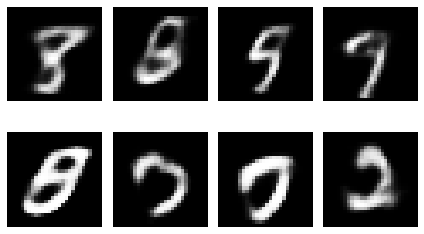

In [52]:
batch_size=8

z = torch.randn(batch_size, 10, device=device)

model.eval()

images = model.decoder(z)
images = images.view(-1, 28, 28)
images = images.squeeze().detach().cpu().numpy()

for i, image in enumerate(images):
    plt.subplot(2, 4, i+1)
    plt.imshow(image, cmap='binary_r')
    plt.axis('off')
plt.tight_layout()
plt.show()

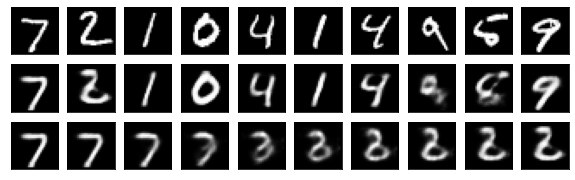

In [58]:
fig = plt.figure(figsize=(10,3))

for x, t in test_dataloader:
    for i, im in enumerate(x.view(-1, 28, 28).detach().numpy()[:10]):
        ax = fig.add_subplot(3, 10, i+1, xticks=[], yticks=[])
        ax.imshow(im, 'gray')
    
    x = x.to(device)
    y, z = model(x)
    y = y.view(-1, 28, 28)
    for i, im in enumerate(y.cpu().detach().numpy()[:10]):
        ax = fig.add_subplot(3, 10, i+11, xticks=[],yticks=[])
        ax.imshow(im, 'gray')
    z1to0 = torch.cat([z[1] * (i*0.1) + z[0] * ((9 - i)* 0.1) for i in range(10)]).reshape(10, 10)
    y2 = model.decoder(z1to0).view(-1, 28, 28)

    for i, im in enumerate(y2.cpu().detach().numpy()):
        ax = fig.add_subplot(3, 10, i+21, xticks=[], yticks=[])
        ax.imshow(im, 'gray')
    break